# **New dataset generation**
This notebook takes the original alignet dataset and creates the new one. It extracts the different trajectories and redistributes them in a new folder architecture.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import os

In [3]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['SynthCars', 'SynthCarsPersons', 'Synth20', 'Synth20others', 'KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

Utils to fix the json meta files. Convert to array.

In [4]:
def to_arr(value):
    """ Converts a string with float values to an actual list of floats """
    return [float(name) for name in value.split()]

def fix_meta(meta):
    """ Converts all the string coded values to lists """
    meta['start_position'] = to_arr(meta['start_position'])
    meta['end_position'] = to_arr(meta['end_position'])
    meta['translation'] = to_arr(meta['translation'])

Util to plot positions.

In [5]:
def plot_points(values):
    positions_s = {'x':[], 'y':[]}
    for obs in values:
        positions_s['x'].append(obs['start_position'][0])
        positions_s['y'].append(obs['start_position'][1])
    positions_e = {'x':[], 'y':[]}
    for obs in values:
        positions_e['x'].append(obs['end_position'][0])
        positions_e['y'].append(obs['end_position'][1])

    plt.scatter(positions_s['x'], positions_s['y'])
    plt.scatter(positions_e['x'], positions_e['y'])

None of the synthetic datasets works for us as they don't contain any trajectory. So I will only work in the KITTI datasets.

### **KITTI datasets**

1.Load all the meta.json

In [6]:
# Create dataset path
dataset_path = os.path.join(datasets_path, all_datasets[4]) 
# Loads all jsons and stores them in a list(container)
container = list()
for i in range(10000):
    # Create path and load file
    file_path = os.path.join(dataset_path, "meta", str(i).zfill(8)+'.json')
    with open(file_path) as json_file: meta_dict = json.load(json_file)
    # Convert the string to lists
    fix_meta(meta_dict)
    meta_dict['filename'] = str(i).zfill(8)
    # Append to file
    container.append(meta_dict)

2.Slice the files by 'seq' and 'trackids' parameters

In [7]:
# Get unique seq_ids in the list of dicts
seqs = list(set(meta['seq'] for meta in container)) 

# Store the correct meta files in each dict key (seq_ids)
seq_metas = {seq: [] for seq in seqs}
for meta in container: 
    seq_metas[meta['seq']].append(meta)

In [8]:
# Get unique seq_ids in the list of dicts
seqs = list(set(meta['seq'] for meta in container)) 

# Store the correct meta files in each dict key (seq_ids)
seq_metas = {seq: [] for seq in seqs}
for meta in container: 
    seq_metas[meta['seq']].append(meta)

seq_track_metas = dict()

for seq_id in seq_metas.keys():    
    # This is a list containing all the meta dicts of specific seq_id
    curr_metas = seq_metas[seq_id] 
    
    # Get unique trackids in the dicts
    track_ids = list(set(meta['trackids'][0] for meta in curr_metas)) 
    
    # Store the different metas at each key (track_ids)
    track_metas = {idn: [] for idn in track_ids}
    for meta in curr_metas: 
        track_metas[meta['trackids'][0]].append(meta)
    
    # The seq_id is used as key to store the computed dict
    # The output is a dict of dicts
    seq_track_metas[seq_id] = track_metas

2.1.Check the resulting results

In [9]:
# Get possible keys for the seq_track_metas double dict
key_dict = {key: list(seq_track_metas[key].keys()) for key in seq_track_metas.keys()}

In [10]:
key_dict[0]

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]

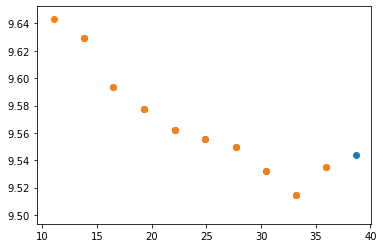

In [11]:
# Handcheck of the resulting paths
plot_points(seq_track_metas[4][30])

3.Export to the desired folder structure

In [12]:
# Util to create folders
import pathlib
def mk_folder(path):    
    """ Util to create folder NO COMPLAINS! """
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)

In [13]:
# Create folder (new_datasets)
new_path = os.path.join(home_path, 'project_data', 'new_datasets')

mk_folder(new_path)

In [14]:
# Different keys to access by
key_dict = {key: list(seq_track_metas[key].keys()) for i, key in enumerate(seq_track_metas.keys())}

In [15]:
# TODO: Comment all of this!
for seq_id in seq_track_metas.keys():
    for track_id in seq_track_metas[seq_id].keys():

        curr_folder_path = os.path.join(new_path,str(seq_id),str(track_id))
        mk_folder(curr_folder_path)

        curr_trajectory = seq_track_metas[seq_id][track_id]

        for time_point in curr_trajectory:
            outputfile_path = os.path.join(curr_folder_path, f"{time_point['filename']}.json")
            with open(outputfile_path, 'w') as json_file:
                json.dump(time_point, json_file, indent=4)

4.Convert the code to functions

In [16]:
def to_arr(value):
    """ Converts a string with float values to an actual list of floats """
    return [float(name) for name in value.split()]

def fix_meta(meta):
    """ Converts all the string coded values to lists """
    meta['start_position'] = to_arr(meta['start_position'])
    meta['end_position'] = to_arr(meta['end_position'])
    meta['translation'] = to_arr(meta['translation'])

In [17]:
# Util to create folders
import pathlib
def mk_folder(path):    
    """ Util to create folder NO COMPLAINS! """
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)

In [18]:
# Functions to store single seq_ids and track_ids to folders
def store_single_path(curr_folder_path, curr_trajectory):
    for time_point in curr_trajectory:
        outputfile_path = os.path.join(curr_folder_path, f"{time_point['filename']}.json")
        with open(outputfile_path, 'w') as json_file:
            json.dump(time_point, json_file, indent=4)
    

def store_seq(new_path, seq_track_metas):
    for seq_id in seq_track_metas.keys():
        print(f"\tConverting {seq_id}...")
        for track_id in seq_track_metas[seq_id].keys():

            curr_folder_path = os.path.join(new_path,str(seq_id),str(track_id))
            mk_folder(curr_folder_path)

            curr_trajectory = seq_track_metas[seq_id][track_id]

            store_single_path(curr_folder_path, curr_trajectory)

In [19]:
# Create dataset path
def load_all_metas(dataset_path):
    # Loads all jsons and stores them in a list(container)
    container = list()
    meta_path = os.path.join(dataset_path, "meta")
    for filename in sorted(os.listdir(meta_path)):
        # Create path and load file
        file_path = os.path.join(meta_path, filename)
        with open(file_path) as json_file: meta_dict = json.load(json_file)
        # Convert the string to lists
        fix_meta(meta_dict)
        meta_dict['filename'] = filename[:-5]
        # Append to file
        container.append(meta_dict)
    
    return container

In [20]:
def slice_seq_track(all_metas): 
    # Get unique seq_ids in the list of dicts
    seqs = list(set(meta['seq'] for meta in all_metas)) 

    # Store the correct meta files in each dict key (seq_ids)
    seq_metas = {seq: [] for seq in seqs}
    for meta in all_metas: 
        seq_metas[meta['seq']].append(meta)

    seq_track_metas = dict()

    for seq_id in seq_metas.keys():    
        # This is a list containing all the meta dicts of specific seq_id
        curr_metas = seq_metas[seq_id] 

        # Get unique trackids in the dicts
        track_ids = list(set(meta['trackids'][0] for meta in curr_metas)) 

        # Store the different metas at each key (track_ids)
        track_metas = {idn: [] for idn in track_ids}
        for meta in curr_metas: 
            track_metas[meta['trackids'][0]].append(meta)

        # The seq_id is used as key to store the computed dict
        # The output is a dict of dicts
        seq_track_metas[seq_id] = track_metas
    
    return seq_track_metas

In [21]:
def create_name_container(seq_track_metas):
    """  """
    name_container = dict()
    for seq_id in seq_track_metas.keys():
        for track_id in seq_track_metas[seq_id].keys():
            names = [meta['filename'] for meta in seq_track_metas[0][0]]
            name_container[f'{seq_id}_{track_id}'] = names
            
    return name_container

In [22]:
name_cont = create_name_container(seq_track_metas)

In [23]:
import json
with open('name_container.txt', 'w') as outfile:
    json.dump(name_cont, outfile)

In [24]:
# Path definition
home_path = '/home/usuario/'
datasets_path = os.path.join(home_path, 'project_data', 'datasets')
new_path = os.path.join(home_path, 'project_data', 'new_datasets')

# This are all the KITTI datasets we can use
KITTIDatasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']


for name in KITTIDatasets:
    print(f"Now converting {name}")
    
    # 1.Load all metas from dataset
    # datasets_path should be from class
    dataset_path = os.path.join(datasets_path, name)
    all_metas = load_all_metas(dataset_path)
    
    # 2.Slice datasets by seq_id and track_id
    seq_track_metas = slice_seq_track(all_metas)
    
    # 3.Store paths
    # Create paths and folder
    destination_path = os.path.join(new_path, name)
    mk_folder(new_path)
    
    store_seq(destination_path, seq_track_metas)

print("Done!")

Now converting KITTITrackletsCars
	Converting 0...
	Converting 1...
	Converting 2...
	Converting 3...
	Converting 4...
	Converting 5...
	Converting 6...
	Converting 7...
	Converting 8...
	Converting 9...
	Converting 10...
	Converting 11...
	Converting 12...
	Converting 13...
	Converting 14...
	Converting 15...
	Converting 16...
	Converting 18...
	Converting 19...
	Converting 20...
Now converting KITTITrackletsCarsPersons
	Converting 0...
	Converting 1...
	Converting 2...
	Converting 3...
	Converting 4...
	Converting 5...
	Converting 6...
	Converting 7...
	Converting 8...
	Converting 9...
	Converting 10...
	Converting 11...
	Converting 12...
	Converting 13...
	Converting 14...
	Converting 15...
	Converting 16...
	Converting 17...
	Converting 18...
	Converting 19...
	Converting 20...
Now converting KITTITrackletsCarsHard
	Converting 0...
	Converting 1...
	Converting 2...
	Converting 4...
	Converting 7...
	Converting 9...
	Converting 12...
	Converting 14...
	Converting 15...
	Converting 2

In [25]:
seq_track_metas[1].keys()

dict_keys([93, 94])

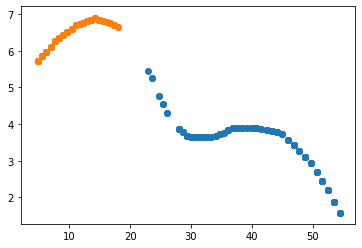

In [26]:
plot_points(seq_track_metas[1][94])

In [27]:
seq_track_metas[1][94]

[{'start_position': [52.544193267822266,
   2.2031490802764893,
   -0.6878499984741211],
  'start_angle': 2.5772929191589355,
  'end_position': [5.5170369148254395, 5.846316814422607, -1.1141159534454346],
  'end_angle': 1.3814680576324463,
  'translation': [-47.027156352996826, 3.643167734146118, 0.0],
  'rel_angle': -1.1958248615264893,
  'class': 'Car',
  'truncated': 0,
  'occluded': 1,
  'seq': 1,
  'frames': [342, 408],
  'trackids': [94, 94],
  'vo1': '2.613649964332580566e-01 -9.652310013771057129e-01 4.092520102858543396e-03 2.105310058593750000e+02\n9.612399935722351074e-01 2.606649994850158691e-01 8.984140306711196899e-02 1.157399978637695312e+02\n-8.778449892997741699e-02 -1.954749971628189087e-02 9.959480166435241699e-01 -1.144089984893798828e+01\n-8.412910167839818439e-16 1.042010005544889641e-16 -4.688869993534387163e-18 1.000000000000000000e+00\n',
  'vo2': '2.812629938125610352e-01 -9.596310257911682129e-01 2.321750071132555604e-04 2.178869934082031250e+02\n9.564260244